In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import STL
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import pmdarima as pm
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

In [35]:
data = pd.read_csv('cardox.csv')
data

,date,value
0,1958-03-01,315.71
1,1958-04-01,317.45
2,1958-05-01,317.50
3,1958-06-01,317.10
4,1958-07-01,315.86
...,...,...
724,2018-07-01,408.71
725,2018-08-01,406.99
726,2018-09-01,405.51
727,2018-10-01,406.00


In [36]:
data.describe()

,value
count,729.000000
mean,353.787229
std,27.547500
min,312.660000
25%,328.570000
50%,351.410000
75%,375.990000
max,411.240000


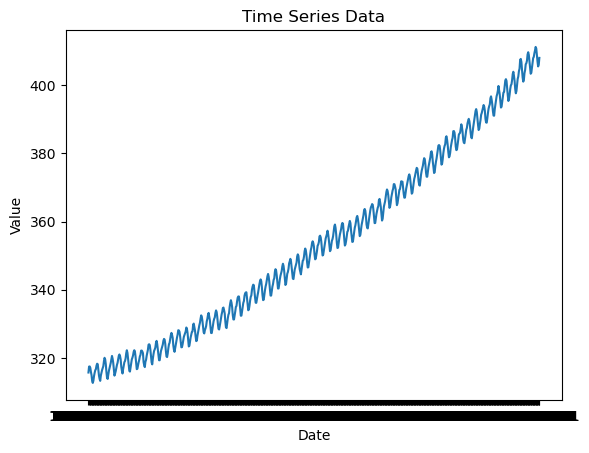

In [37]:
plt.plot(data['date'], data['value'])
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Time Series Data')
plt.show()

In [38]:
mean = np.mean(data['value'])
std = np.std(data['value'])
threshold = 3  # Порігове значення

anomalies = data[np.abs(data['value'] - mean) > (threshold * std)]
anomalies
#аномалії не виявлені (на графіку також це видно)

,date,value


In [39]:
# Перетворення стовпця 'Дата' в тип дати
data['date'] = pd.to_datetime(data['date'])

# Встановлення стовпця 'Дата' як індексу
data.set_index('date', inplace=True)

# Декомпозиція ряду за допомогою методу STL
stl = STL(data['value'], seasonal=13)
result = stl.fit()

# Отримання тренду, сезонності та залишку
trend = result.trend
seasonal = result.seasonal
residual = result.resid

# Коригування ряду шляхом віднімання тренду та сезонності
adjusted = data['value'] - trend - seasonal

# Заповнення пропущених значень за допомогою SimpleImputer
imputer = SimpleImputer(strategy='mean')
filled_values = imputer.fit_transform(data[['value']])
data['value_filled'] = filled_values

# Виведення результатів
print("Тренд:")
print(trend)
print("Сезонність:")
print(seasonal)
print("Залишок:")
print(residual)
print("Скоригований ряд:")
print(adjusted)
print("Ряд з заповненими значеннями:")
print(data)

Тренд:
date
1958-03-01    314.964857
1958-04-01    315.035611
1958-05-01    315.105098
1958-06-01    315.173037
1958-07-01    315.239337
                 ...    
2018-07-01    408.641183
2018-08-01    408.836537
2018-09-01    409.034769
2018-10-01    409.236190
2018-11-01    409.440834
Name: trend, Length: 729, dtype: float64
Сезонність:
date
1958-03-01    0.880997
1958-04-01    2.143806
1958-05-01    2.692995
1958-06-01    2.224720
1958-07-01    0.767000
                ...   
2018-07-01    0.186442
2018-08-01   -1.995562
2018-09-01   -3.744275
2018-10-01   -3.367466
2018-11-01   -1.711228
Name: season, Length: 729, dtype: float64
Залишок:
date
1958-03-01   -0.135854
1958-04-01    0.270583
1958-05-01   -0.298093
1958-06-01   -0.297758
1958-07-01   -0.146336
                ...   
2018-07-01   -0.117624
2018-08-01    0.149025
2018-09-01    0.219506
2018-10-01    0.131276
2018-11-01    0.290394
Name: resid, Length: 729, dtype: float64
Скоригований ряд:
date
1958-03-01   -0.135854
1958-0

In [40]:
# Розділення датасету на ознаки та цільову змінну
X = data.dropna().drop('value', axis=1)
y = data.dropna()['value']

# Розділення на тренувальний та тестувальний набори даних
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ініціалізація моделі
model = LinearRegression()

# Навчання моделі
model.fit(X_train, y_train)

# Оцінка метрик на тестовому наборі даних
y_pred = model.predict(X_test)
metric1_score = mean_squared_error(y_test, y_pred)
metric2_score = r2_score(y_test, y_pred)

# Виведення результатів
print("mean_squared_error:", metric1_score)
print("r2_score:", metric2_score)

mean_squared_error: 0.0
r2_score: 1.0


In [41]:
#Оцінка метрик моделі
cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
cv_scores = -cv_scores  # Перетворення в позитивне значення середньоквадратичної помилки

print("Cross-Validation scores:", cv_scores)
print("Mean CV score:", cv_scores.mean())
print("Standard deviation of CV scores:", cv_scores.std())

Cross-Validation scores: [0.00000000e+00 0.00000000e+00 0.00000000e+00 6.63939918e-29
 2.98605070e-27]
Mean CV score: 6.104889388893481e-28
Standard deviation of CV scores: 1.188059193674355e-27


C:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


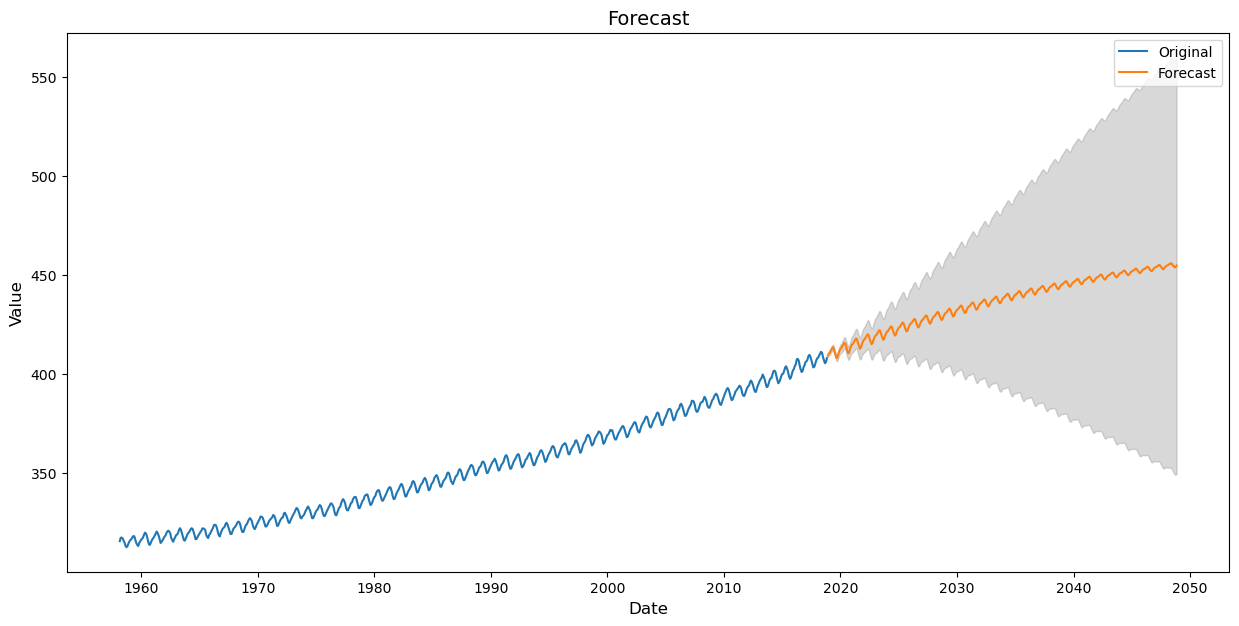

In [42]:
# Робимо прогноз на 30 років
# Побудова моделі SARIMA
model = SARIMAX(data['value'], order=(1, 1, 1), seasonal_order=(1, 0, 0, 12))
model_fit = model.fit()

# Прогноз на 30 років
forecast = model_fit.get_forecast(steps=360)

# Отримання прогнозованих значень та довірчого інтервалу
forecast_values = forecast.predicted_mean
confidence_interval = forecast.conf_int()

# Побудова графіку
plt.figure(figsize=(15, 7))
plt.plot(data.index, data['value'], label='Original')
plt.plot(forecast_values.index, forecast_values, label='Forecast')
plt.fill_between(confidence_interval.index, confidence_interval.iloc[:, 0], confidence_interval.iloc[:, 1], color='gray', alpha=0.3)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.title('Forecast', fontsize=14)
plt.legend(loc='best')

plt.show()

In [43]:
forecast_values = forecast.predicted_mean
forecast_values.to_csv('forecast_results.csv')